# Environment Setup 

In [1]:
import os
import numpy as np
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.impute import KNNImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import PartialDependenceDisplay
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import cross_val_score
import xgboost as xgb

In [2]:
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

df_raw = pd.read_csv("/kaggle/input/house-prices-advanced-regression-techniques/train.csv")
print("df Shape: ",df_raw.shape)
print(df_raw.columns)
df_raw.describe()

/kaggle/input/house-prices-advanced-regression-techniques/sample_submission.csv
/kaggle/input/house-prices-advanced-regression-techniques/data_description.txt
/kaggle/input/house-prices-advanced-regression-techniques/train.csv
/kaggle/input/house-prices-advanced-regression-techniques/test.csv
df Shape:  (1460, 81)
Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF',

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,...,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,...,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,...,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,...,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,...,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


# Random Forest with Scikit-Learn

## Preprocessing

In [12]:
df = df_raw.copy()
y = np.log(df['SalePrice'])
X = df.drop('SalePrice',axis=1)

print("Total Features:",len(X.columns))
numeric_features = X.select_dtypes(include=['number']).columns.tolist()
categorical_features = X.select_dtypes(include=['object', 'category']).columns.tolist()
print("Numeric:", len(numeric_features),"Categorical",len(categorical_features))

Total Features: 80
Numeric: 37 Categorical 43


## Basic Model Function for Iteration

In [13]:
def create_and_evaluate_model(X, y):
    numeric_features = X.select_dtypes(include=['number']).columns.tolist()
    categorical_features = X.select_dtypes(include=['object', 'category']).columns.tolist()
    
    numeric_transformer = SimpleImputer(strategy='constant')
    
    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ])

    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_features),
            ('cat', categorical_transformer, categorical_features)
    ])
    
    model_pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', GradientBoostingRegressor(n_estimators=100, random_state=42))
    ])
    
    X_train, x_valid, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    model_pipeline.fit(X_train, y_train)
    y_pred = model_pipeline.predict(x_valid)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    print(f"Root Mean Squared Error Basic Model: {rmse}")

In [14]:
create_and_evaluate_model(X, y)

Root Mean Squared Error Basic Model: 0.12960907503886596


In [15]:
def create_and_evaluate_model(X, y):
    df = df_raw.copy()
    y = np.log(df['SalePrice'])
    X = df.drop('SalePrice',axis=1)

    numeric_features = X.select_dtypes(include=['number']).columns.tolist()
    categorical_features = X.select_dtypes(include=['object', 'category']).columns.tolist()
    
    numeric_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='median')),
    ])
    
    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='constant', fill_value='Missing')),
        ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ])

    preprocessor = ColumnTransformer(transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])
    
    model_pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', xgb.XGBRegressor(
            n_estimators=1000,
            learning_rate=0.05,
            max_depth=5,
            subsample=0.8,
            colsample_bytree=0.8,
            random_state=42
        ))
    ])
    
    scores = cross_val_score(model_pipeline, X, y, cv=5, scoring='neg_root_mean_squared_error')
    print(f"Average RMSE: {-scores.mean()}")
    
    X_train, x_valid, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    model_pipeline.fit(X_train, y_train)
    y_pred = model_pipeline.predict(x_valid)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    print(f"Root Mean Squared Error (RMSE) on Validation Set: {rmse}")
    return model_pipeline

In [16]:
best_model = create_and_evaluate_model(X, y)
best_model

Average RMSE: 0.1255834870529787
Root Mean Squared Error (RMSE) on Validation Set: 0.12894868782601776


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median'))]),
                                                  ['Id', 'MSSubClass',
                                                   'LotFrontage', 'LotArea',
                                                   'OverallQual', 'OverallCond',
                                                   'YearBuilt', 'YearRemodAdd',
                                                   'MasVnrArea', 'BsmtFinSF1',
                                                   'BsmtFinSF2', 'BsmtUnfSF',
                                                   'TotalBsmtSF', '1stFlrSF',
                                                   '2ndFlrSF', 'LowQualFinSF',
                                                   'GrLivArea', 'Bsm...
                              feature_types=None, gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=0.05,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=5, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=1000, n_jobs=None,
                              num_parallel_tree=None, random_state=42, ...))])

## Feature Engineering

In [21]:
X_train, x_valid, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [22]:
model = best_model.named_steps['model']
importances = model.feature_importances_
ohe_feature_names = best_model.named_steps['preprocessor'].transformers_[1][1].get_feature_names_out(categorical_features)
features = numeric_features + list(ohe_feature_names)


feature_importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': importances
})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

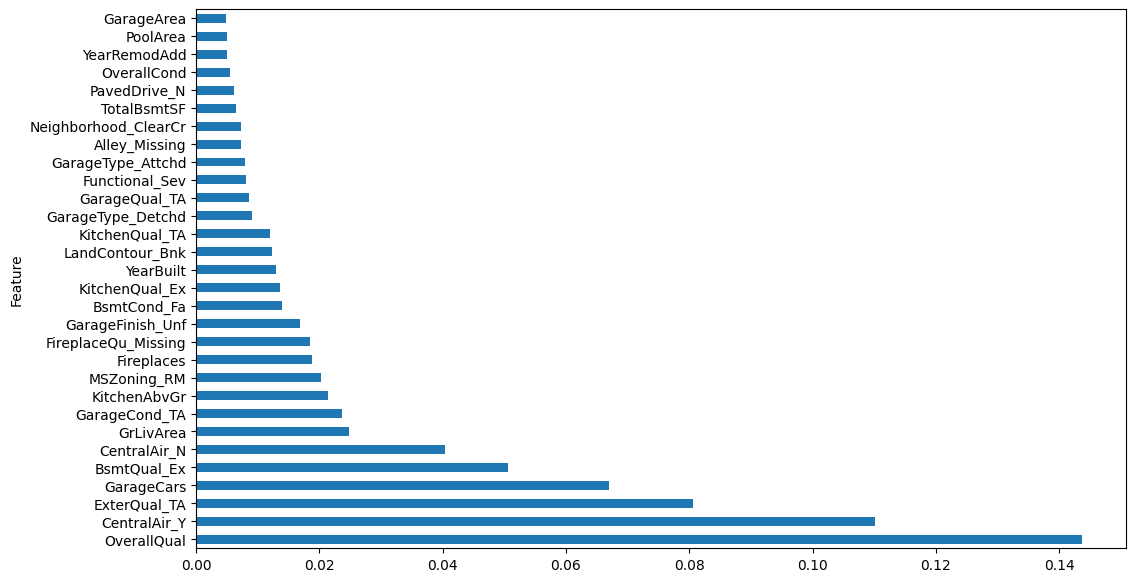

In [23]:
feature_importance_df[:30].plot('Feature', 'Importance', 'barh', figsize=(12,7), legend=False);

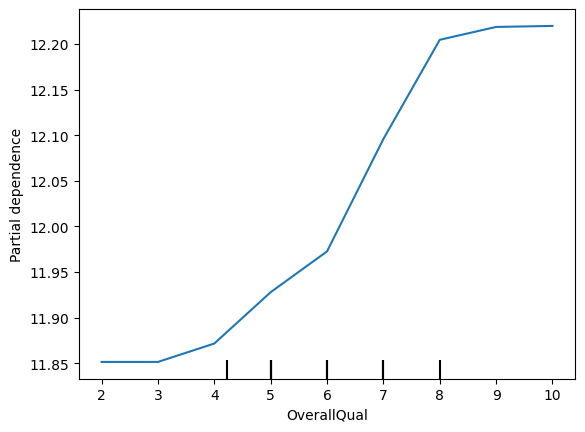

In [24]:
PartialDependenceDisplay.from_estimator(best_model, x_valid, ['OverallQual']);

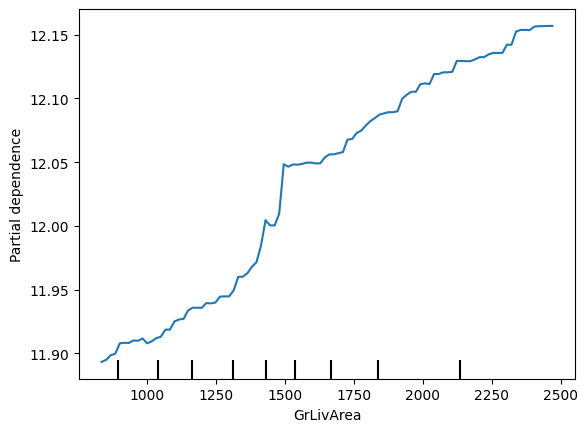

In [25]:
PartialDependenceDisplay.from_estimator(best_model, x_valid, ['GrLivArea']);

## Hyperparameter Tuning

In [27]:
# param_dist = {
#     'model__n_estimators': [100, 200, 300, 400],
#     'model__learning_rate': [0.01, 0.05, 0.1, 0.2],
#     'model__max_depth': [3, 4, 5, 6],
#     'model__min_samples_split': [2, 5, 10],
#     'model__min_samples_leaf': [1, 2, 4],
#     'model__subsample': [0.8, 0.9, 1.0]
# }

# random_search = RandomizedSearchCV(
#     estimator=best_model,
#     param_distributions=param_dist,
#     n_iter=20,  
#     cv=5,  
#     verbose=1,
#     random_state=42,
#     n_jobs=-1,  
#     scoring='neg_mean_squared_error'
# )

# random_search.fit(X_train, y_train)

# best_model_tuned = random_search.best_estimator_
# print(f"Best parameters found: {random_search.best_params_}")

# y_pred = best_model_tuned.predict(x_valid)
# mse = mean_squared_error(y_test, y_pred)
# rmse = np.sqrt(mse)
# print(f"Root Mean Squared Error (RMSE) with tuned hyperparameters: {rmse}")

## Submission

In [28]:
X_test = pd.read_csv("/kaggle/input/house-prices-advanced-regression-techniques/test.csv")
y_pred_test = best_model.predict(X_test)
submission = pd.DataFrame({
    'Id': X_test['Id'], 
    'SalePrice': np.exp(y_pred_test)
})

submission.to_csv('submission.csv', index=False)
print("Submission file 'submission.csv' created successfully.")

Submission file 'submission.csv' created successfully.
